In [1]:
import re
from rebin import rebin
import numpy as np
from warnings import warn
import os
from skimage.registration import phase_cross_correlation as cross_correl
from skimage.transform import EuclideanTransform, warp
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import matplotlib as mpl
import shutil
from tqdm.autonotebook import tqdm

/tmp/ipykernel_20012/1786261465.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def read_image(
    filepath,
    additional_bins=0,
    norm="div",
    rem_start_pts=1,
    rem_end_pts=0,
    ROI=None,
):
    with open(os.path.normpath(filepath), mode="r") as fid:
        raw_data = np.fromfile(fid, dtype=np.float32)[2:]

    # pl_image, sig, ref, sig_norm, sweep_list, roi
    return _reshape_raw(
        raw_data,
        filepath,
        additional_bins,
        norm,
        rem_start_pts,
        rem_end_pts,
        ROI,
    )


def read_metadata(filepath):
    with open(os.path.normpath(str(filepath) + "_metaSpool.txt"), "r") as fid:
        _ = fid.readline().rstrip().split("\t")
        rest_str = fid.read()
        matches = re.findall(
            r"([^\t\n]+):\s([^\t\n]+)",
            rest_str,
            re.MULTILINE,
        )

        def failfloat(a):
            try:
                return float(a)
            except ValueError:
                if a == "FALSE":
                    return False
                elif a == "TRUE":
                    return True
                else:
                    return a

        metadata = {a: failfloat(b) for (a, b) in matches}
    return metadata


# ============================================================================


def _read_sweep_list(filepath):
    with open(os.path.normpath(str(filepath) + "_metaSpool.txt"), "r") as fid:
        sweep_str = fid.readline().rstrip().split("\t")
    return [float(i) for i in sweep_str]


# ============================================================================


def _check_start_end_rectangle(
    name, start_x, start_y, end_x, end_y, full_size_w, full_size_h
):
    if start_x >= end_x:
        warn(f"{name} Rectangle ends before it starts (in x), swapping them")
        start_x, end_x = end_x, start_x
    if start_y >= end_y:
        warn(f"{name} Rectangle ends before it starts (in y), swapping them")
        start_y, end_y = end_y, start_y
    if start_x >= full_size_w:
        warn(
            f"{name} Rectangle starts outside image (too large in x), setting to zero."
        )
        start_x = 0
    elif start_x < 0:
        warn(
            f"{name} Rectangle starts outside image (negative in x), setting to zero.."
        )
        start_x = 0

    if start_y >= full_size_h:
        warn(
            f"{name} Rectangle starts outside image (too large in y), setting to zero."
        )
        start_y = 0
    elif start_y < 0:
        warn(
            f"{name}  Rectangle starts outside image (negative in y), setting to zero."
        )
        start_y = 0

    if end_x >= full_size_w:
        warn(
            f"{name} Rectangle too big in x, cropping to image.\n"
            + f"Image dimensions (x,y): ({full_size_w},{full_size_h})"
        )
        end_x = full_size_w - 1
    if end_y >= full_size_h:
        warn(
            f"{name} Rectangle too big in y, cropping to image.\n"
            + f"Image dimensions (x,y): ({full_size_w},{full_size_h})"
        )
        end_y = full_size_h - 1

    return (start_x, start_y), (end_x, end_y)


# ============================================================================


def _define_roi(ROI, full_size_h, full_size_w):
    if ROI is None:
        roi = _define_area_roi(0, 0, full_size_w - 1, full_size_h - 1)
    else:
        start_x, start_y = ROI["start"]
        end_x, end_y = ROI["end"]
        roi = _define_area_roi(start_x, start_y, end_x, end_y)
    return roi


# ============================================================================


def _define_area_roi(start_x, start_y, end_x, end_y):
    x = np.linspace(start_x, end_x, end_x - start_x + 1, dtype=int)
    y = np.linspace(start_y, end_y, end_y - start_y + 1, dtype=int)
    xv, yv = np.meshgrid(x, y)
    return [
        yv,
        xv,
    ]  # arrays are indexed in image convention, e.g. sig[sweep_param, y, x]


# ============================================================================


def _remove_unwanted_data(
    image_rebinned,
    sweep_list,
    sig,
    ref,
    sig_norm,
    rem_start=1,
    rem_end=0,
    ROI=None,
):
    end = -rem_end if rem_end > 0 else None

    roi = _define_roi(ROI, *image_rebinned.shape[1:])

    if rem_start < 0:
        warn("remove_start_sweep must be >=0, setting to zero now.")
        rem_start = 0
    if rem_end < 0:
        warn("remove_end_sweep must be >=0, setting to zero now.")
        rem_end = 0

    pl_image = np.sum(image_rebinned, axis=0)

    return (
        pl_image,
        sig[rem_start:end].copy(),
        ref[rem_start:end].copy(),
        sig_norm[rem_start:end].copy(),
        np.asarray(sweep_list[rem_start:end]).copy(),
        roi,
    )


# ============================================================================


def crop_roi(seq, roi):
    if len(np.shape(seq)) == 2:
        return seq[roi[0], roi[1]].copy()
    else:
        return seq[:, roi[0], roi[1]].copy()


# ============================================================================


def _reshape_raw(
    raw_data,
    filepath,
    additional_bins=0,
    norm="div",
    rem_start_pts=1,
    rem_end_pts=0,
    ROI=None,
):
    sweep_list = _read_sweep_list(filepath)
    metadata = read_metadata(filepath)
    try:
        data_pts = len(sweep_list)
        image = np.reshape(
            raw_data,
            [
                data_pts,
                int(metadata["AOIHeight"]),
                int(metadata["AOIWidth"]),
            ],
        )
        used_ref = False
    except ValueError:
        data_pts = 2 * len(sweep_list)
        image = np.reshape(
            raw_data,
            [
                data_pts,
                int(metadata["AOIHeight"]),
                int(metadata["AOIWidth"]),
            ],
        )
        used_ref = True

    im = image.transpose([0, 2, 1]).copy()
    return _reshape_dataset(
        im,
        sweep_list,
        additional_bins,
        used_ref,
        norm,
        rem_start_pts,
        rem_end_pts,
        ROI,
    )

# ============================================================================

def _rebin_image(image, additional_bins=0, used_ref=True, norm="div"):
    if not additional_bins:
        image_rebinned = np.array(image)
    else:
        if additional_bins != 1 and additional_bins % 2:
            raise RuntimeError(
                "The binning parameter needs to be a multiple of 2."
            )

        image_rebinned = np.array(
            rebin(
                image,
                factor=(1, additional_bins, additional_bins),
                func=np.mean,
            )
        )

    # define sig and ref differently if we're using a ref
    if used_ref:
        sig = image_rebinned[::2, :, :]
        ref = image_rebinned[1::2, :, :]
        if norm == "sub":
            sig_norm = 1 + (sig - ref) / (sig + ref)
        elif norm == "div":
            sig_norm = sig / ref
        elif norm == "true_sub":
            sig_norm = (sig - ref) / np.nanmax(sig - ref, axis=0)
        else:
            raise KeyError(
                "bad normalisation option, use: ['sub', 'div', 'true_sub']"
            )
    else:
        sig = image_rebinned
        ref = image_rebinned
        sig_norm = sig / np.max(sig, 0)

    return image_rebinned, sig, ref, sig_norm


# ============================================================================


def _reshape_dataset(
    image,
    sweep_list,
    additional_bins=0,
    used_ref=True,
    norm="div",
    rem_start_pts=1,
    rem_end_pts=0,
    ROI=None,
):
    image_rebinned, sig, ref, sig_norm = _rebin_image(
        image, additional_bins, used_ref, norm
    )
    try:
        size_h, size_w = image_rebinned.shape[1:]
    except Exception:
        size_h, size_w = image_rebinned.shape

    # check options to ensure ROI is in correct format (now we have image size)
    if ROI != None:
        ROI["start"], ROI["end"] = _check_start_end_rectangle(
            "ROI", *ROI["start"], *ROI["end"], size_w, size_h
        )  # opposite convention here, [x, y]

    (pl_image, sig, ref, sig_norm, sweep_list, roi,) = _remove_unwanted_data(
        image_rebinned,
        sweep_list,
        sig,
        ref,
        sig_norm,
        rem_start_pts,
        rem_end_pts,
        ROI,
    )  # also cuts sig etc. down to ROI

    return (
        pl_image,
        sig,
        ref,
        sig_norm,
        sweep_list,
        roi,
    )


# ============================================================================


def _add_colorbar(im, fig, ax, aspect=20, pad_fraction=1, **kwargs):
    divider = make_axes_locatable(ax)
    width = axes_size.AxesY(ax, aspect=1.0 / aspect)
    pad = axes_size.Fraction(pad_fraction, width)
    cax = divider.append_axes("right", size=width, pad=pad)
    cbar = fig.colorbar(im, cax=cax, **kwargs)
    tick_locator = mpl.ticker.MaxNLocator(nbins=5)
    cbar.locator = tick_locator
    cbar.update_ticks()
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.linewidth = 0.5
    return cbar


def plot_image_on_ax(
    fig, ax, image_data, title="", c_map="gray", c_range=None, c_label=""
):
    if c_range is None:
        mx = np.nanmax(np.abs([np.nanmin(image_data), np.nanmax(image_data)]))
        c_range = [-mx, mx]
    im = ax.imshow(image_data, cmap=c_map, vmin=c_range[0], vmax=c_range[1])

    ax.set_title(title)

    cbar = _add_colorbar(im, fig, ax)
    cbar.ax.set_ylabel(c_label, rotation=270)

    return fig, ax


# ============================================================================


def drift_correct(refr_pl, move_pl, target_pl):
    with np.errstate(all="ignore"):
        shift_calc = cross_correl(refr_pl, move_pl, normalization=None)[0]
    tform = EuclideanTransform(translation=[-shift_calc[1], -shift_calc[0]])
    return warp(target_pl, tform, mode="edge"), shift_calc


def drift_correct_stack(refr_pl, move_pl, move_sig_norm):
    # calc's shift in 'mov_pl' to match 'refr_pl' (image regulation) via cross-corr method
    # then applies that to move_sig_norm.
    with np.errstate(all="ignore"):
        shift_calc = cross_correl(refr_pl, move_pl, normalization=None)[0]
    tform = EuclideanTransform(translation=[-shift_calc[1], -shift_calc[0]])

    reg_sig_norm = np.empty(move_sig_norm.shape)
    for i in range(move_sig_norm.shape[0]):
        reg_sig_norm[i, :, :] = warp(
            move_sig_norm[i, :, :], tform, mode="edge"
        )
    return reg_sig_norm, shift_calc


# ============================================================================


def read_drift_correct(
    base_path,
    stub,
    image_seq,
    additional_bins=0,
    norm="div",
    rem_start_pts=0,
    rem_end_pts=0,
    ROI=None,
):
    first = True
    for i in tqdm(image_seq):
        _, sig, ref, _, _, roi = read_image(
            base_path + stub(i),
            additional_bins,
            norm,
            rem_start_pts,
            rem_end_pts,
            ROI,
        )
        if first:
            first = False
            refr_pl = np.sum(sig, axis=0)
            accum_sig = sig.copy()
            accum_ref = ref.copy()
            prev_sig = sig.copy()
            prev_ref = ref.copy()
            continue

        this_sig = sig - prev_sig
        this_ref = ref - prev_ref
        this_pl = np.sum(this_sig, axis=0)
        prev_sig = sig
        prev_ref = ref

        this_sig, shift_calc_stack = drift_correct_stack(
            crop_roi(refr_pl, roi), crop_roi(this_pl, roi), this_sig
        )
        this_ref, shift_calc_stack = drift_correct_stack(
            crop_roi(refr_pl, roi), crop_roi(this_pl, roi), this_ref
        )

        accum_sig += this_sig
        accum_ref += this_ref

    return accum_sig, accum_ref

# ============================================================================


In [3]:
exec(open('../TEST_DATA_PATH.py').read())

In [4]:
IMAGE_SEQ = list(range(9, 11 + 1))
BASE_PATH = TEST_DATA_PATH + "drift_corr_test/"
STUB =  lambda x: f"ODMR - CW_{x}"
ROI = {
    "start": [100, 100],
    "end": [350, 350],
}  # ONLY USED FOR CROSS-CORR -> full array saved
OUTPUT_FILE = BASE_PATH + "ODMR - CW_9-11"

[ 1. -2.]
[ 1. -2.] [ 1. -2.]
[ 1. -3.] [ 1. -3.]


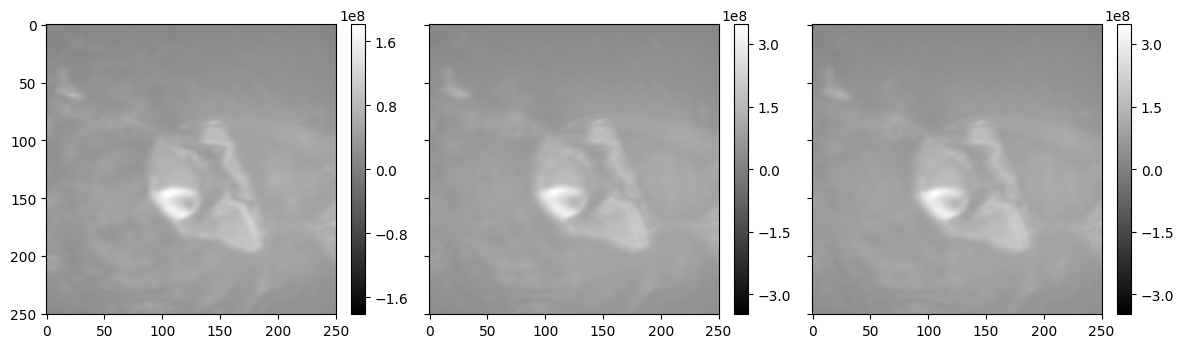

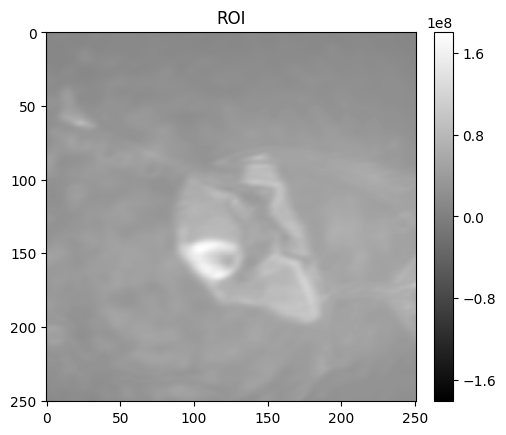

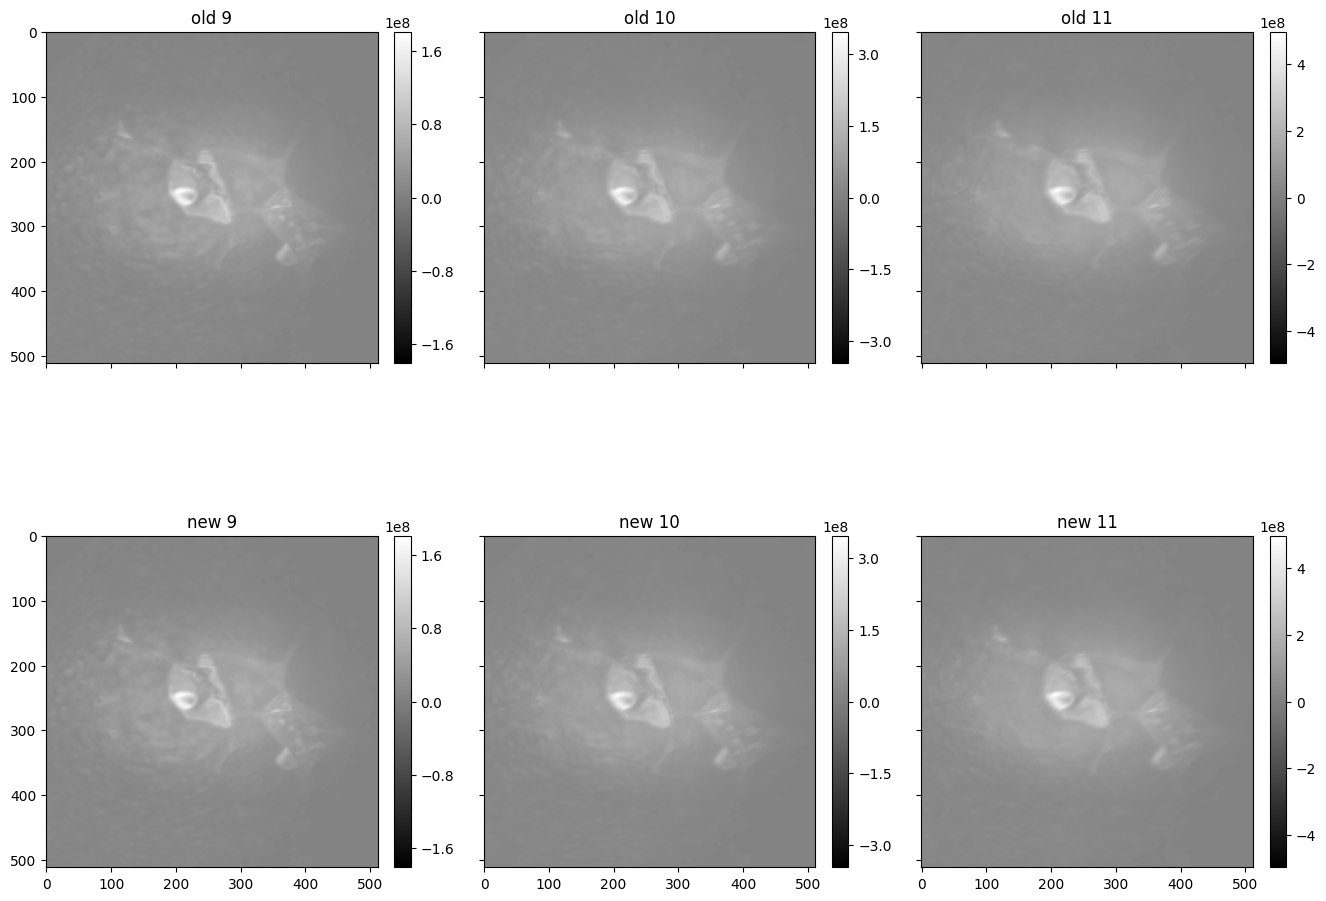

In [5]:
# first test ROI etc.
(refr_pl, _, _, refr_sig_norm, sweep_list, roi) = read_image(
    BASE_PATH + STUB(IMAGE_SEQ[0]), additional_bins=0, norm="div", ROI=ROI
)

(move_pl, _, _, move_sig_norm, sweep_list, roi) = read_image(
    BASE_PATH + STUB(IMAGE_SEQ[1]), additional_bins=0, norm="div", ROI=ROI
)

crop_refr_pl = crop_roi(refr_pl, roi)
crop_move_pl = crop_roi(move_pl, roi)

crop_regr_pl, shift_calc_pl = drift_correct(crop_refr_pl, crop_move_pl, crop_move_pl)
print(shift_calc_pl)
tfig, taxs = plt.subplots(ncols=3, figsize=(14,4), sharex=True, sharey=True)
plot_image_on_ax(tfig, taxs[0], crop_refr_pl)
plot_image_on_ax(tfig, taxs[1], crop_move_pl)
plot_image_on_ax(tfig, taxs[2], crop_regr_pl)

fig, ax = plt.subplots()
plot_image_on_ax(fig, ax, crop_roi(refr_pl, roi), title="ROI")

sig_norms = [refr_sig_norm,]
old_pls = [refr_pl,]
new_pls = [refr_pl,]
for i in IMAGE_SEQ[1:]:
    move_pl, _, _, sig_norm, _, _ = read_image(BASE_PATH + STUB(i))
    
    old_pls.append(move_pl)
    regr_pl, shift_calc_pl = drift_correct(crop_roi(refr_pl, roi), crop_roi(move_pl, roi), move_pl)
    new_pls.append(regr_pl)
    stack, shift_calc_stack = drift_correct_stack(crop_roi(refr_pl, roi), crop_roi(move_pl, roi), sig_norm)
    sig_norms.append(stack)
    print(shift_calc_pl, shift_calc_stack)
    
fig, axs = plt.subplots(ncols=len(IMAGE_SEQ), nrows=2, figsize=(16,12), sharex=True, sharey=True)
for i, f in enumerate(IMAGE_SEQ):
    plot_image_on_ax(fig, axs[0, i], old_pls[i], title=f"old {f}")
    plot_image_on_ax(fig, axs[1, i], new_pls[i], title=f"new {f}")

In [6]:
# now do the real thing

sig, ref = read_drift_correct(BASE_PATH, STUB, IMAGE_SEQ, ROI=ROI)

# output_array = np.vstack((sig.transpose([0, 2, 1]), ref.transpose([0, 2, 1]))).flatten() # correct PL, sweep not interleaved.

# this method is slow but I couldn't get it vectorized
s = sig.transpose([0, 2, 1])
r = ref.transpose([0, 2, 1])

output = []
for f in range(s.shape[0]):
    output.append(s[f, ::])
    output.append(r[f, ::])
output_array = np.array(output).flatten()

with open(OUTPUT_FILE, "wb") as fid:
    np.array([0, 0]).astype(np.float32).tofile(fid)
    output_array.astype(np.float32).tofile(fid)

path = shutil.copyfile(
    BASE_PATH + STUB(IMAGE_SEQ[0]) + "_metaSpool.txt",
    OUTPUT_FILE + "_metaSpool.txt",
)

  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
import qdmpy
import qdmpy.pl
import qdmpy.plot
import qdmpy.field
import qdmpy.source

import matplotlib
import numpy as np

In [8]:
# '%matplotlib widget' allows interactive plots in jupyterlab
# use ''%matplotlib inline' to allow export to pdf
# %matplotlib widget

### Load raw data

In [12]:
binning = 2
options_dict = {
    "filepath": OUTPUT_FILE,
    "custom_output_dir_suffix": "_{fit_backend}_{ROI}_bin_{total_bin}",
    
    "additional_bins": binning,
    
    "exp_reference_type": "field",
    "show_tick_marks": True,
    
    "system_name": "Zyla",

    "ROI": "Rectangle",
    "ROI_start": [50//binning, 100//binning],
    "ROI_end": [200//binning, 200//binning],
    
    "AOI_1_start": [30, 40],
    "AOI_1_end": [40, 45], 
    "AOI_2_start": [20, 20],
    "AOI_2_end": [24, 24], 
    "single_pixel_check": [90, 150],
    
    "fit_backend": "scipyfit",
    "fit_backend_comparison": ["scipyfit"],
    "fit_pl_pixels": True, 
    "force_fit": True, 
    
    "use_ROI_avg_fit_res_for_all_pixels": True,
    
    "scipyfit_sub_threads": 2, 

    "fit_functions":  {"linear": 1, "lorentzian": 1},

    "pos_guess": [3350, 0],
    "pos_range": 25,

    "amp_guess": 0.002,
    "amp_bounds": [0.00003, 0.3],
    
    "fwhm_guess": 50,
    "fwhm_bounds": [3, 100],
    
    "save_fig_type": "pdf",
    
    "freqs_to_use": [1, 0, 0, 0, 0, 0, 0, 0],
    
    "calc_field_pixels": True,
    "force_field_calc": True,
    
    "bfield_bground_method": "poly",
    "bfield_bground_params": {
        "order": 1
    },
    "bnv_bground_method": "poly",
    "bnv_bground_params": {
        "order": 1
    },
    
    "colormap_range_dicts": {
        "bnv_images": {
            "type": "percentile",
            "values": [2, 98]
        },
        "bfield_images": {
            "type": "percentile",
            "values": [2, 98]
        },
        "param_images": {
            "type": "percentile",
            "values": [2, 98]
        },
    }
}
# if you want to use a reference experiment {ensure you run this even if 'None' as it sets up output dirs etc.}
ref_options_dir = None

In [13]:
options, ref_options = qdmpy.initialize(
    options_dict=options_dict,
    ref_options_dir=ref_options_dir,
    set_mpl_rcparams=True
)

/home/samsc/src/qs/qdmpy_proj/qdmpy_git/src/qdmpy/shared/misc.py:17: QDMPYWarning: Continuing without reference. (No reference chosen or exp_referece_type was 'None')
  warnings.warn(msg, QDMPYWarning)


### Load data

/home/samsc/src/qs/qdmpy_proj/qdmpy_git/src/qdmpy/shared/misc.py:17: QDMPYWarning: Avoiding IndexError for single_pixel_check (setting pixel check to centre of image):
index 150 is out of bounds for axis 1 with size 51
  warnings.warn(msg, QDMPYWarning)


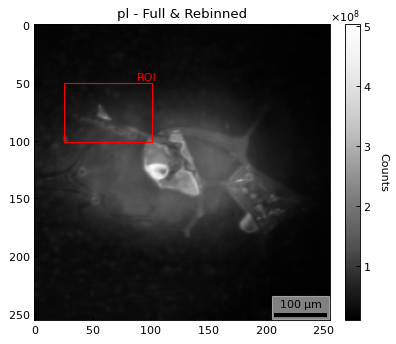

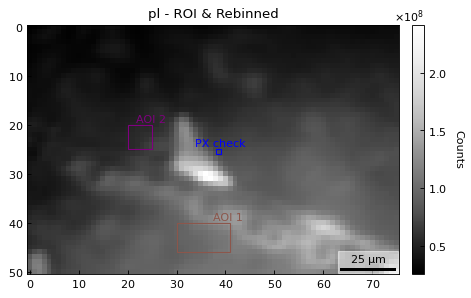

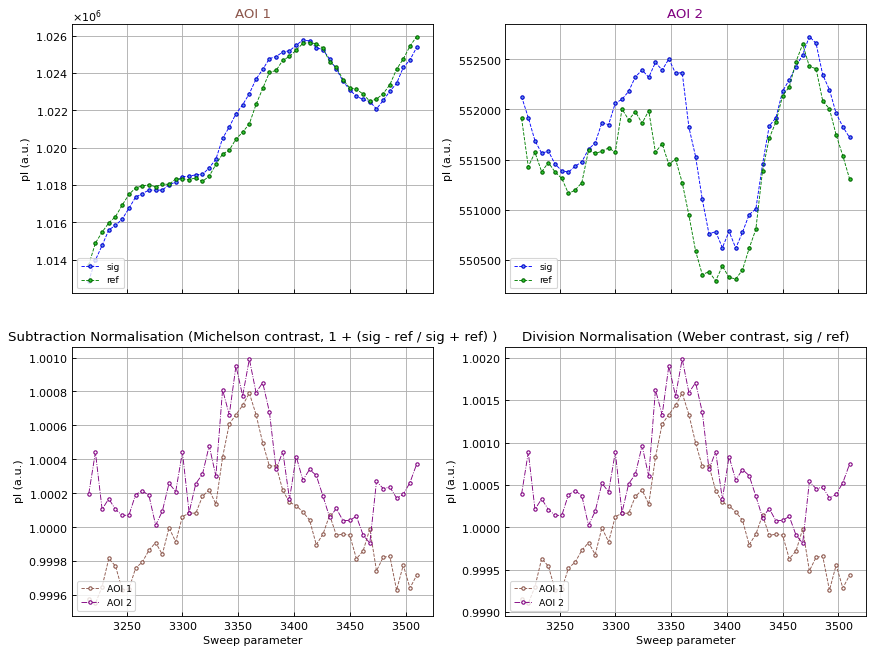

In [14]:
image, prelim_sweep_list = qdmpy.pl.load_image_and_sweep(options)
PL_image, PL_image_ROI, sig, ref, sig_norm, single_pixel_pl, sweep_list, ROI = qdmpy.pl.reshape_dataset(
        options, image, prelim_sweep_list
    )
ROI_PL_fig = qdmpy.plot.roi_pl_image(options, PL_image)

AOI_PL_fig = qdmpy.plot.aoi_pl_image(options, PL_image_ROI)

AOI_spectra_fig = qdmpy.plot.aoi_spectra(options, sig, ref, sweep_list)

qdmpy.pl.save_pl_data(options, PL_image, PL_image_ROI)

### Fit AOI, ROI averages, single pixel

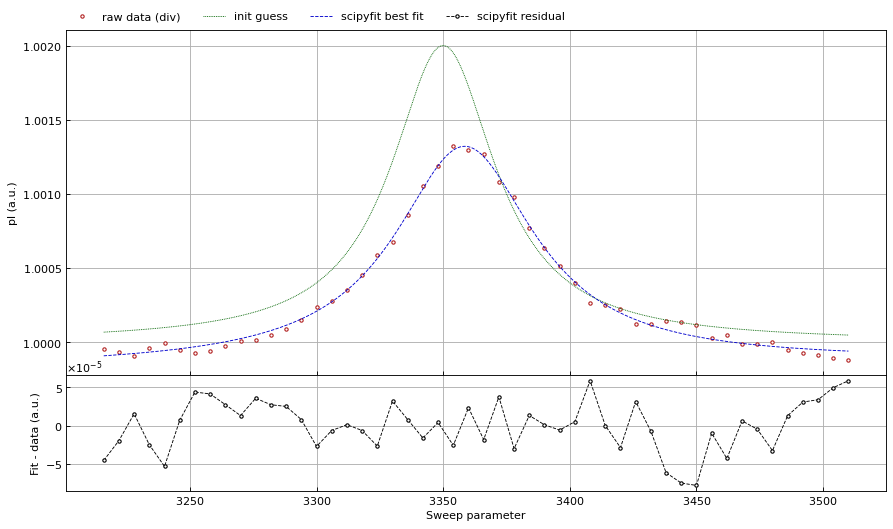

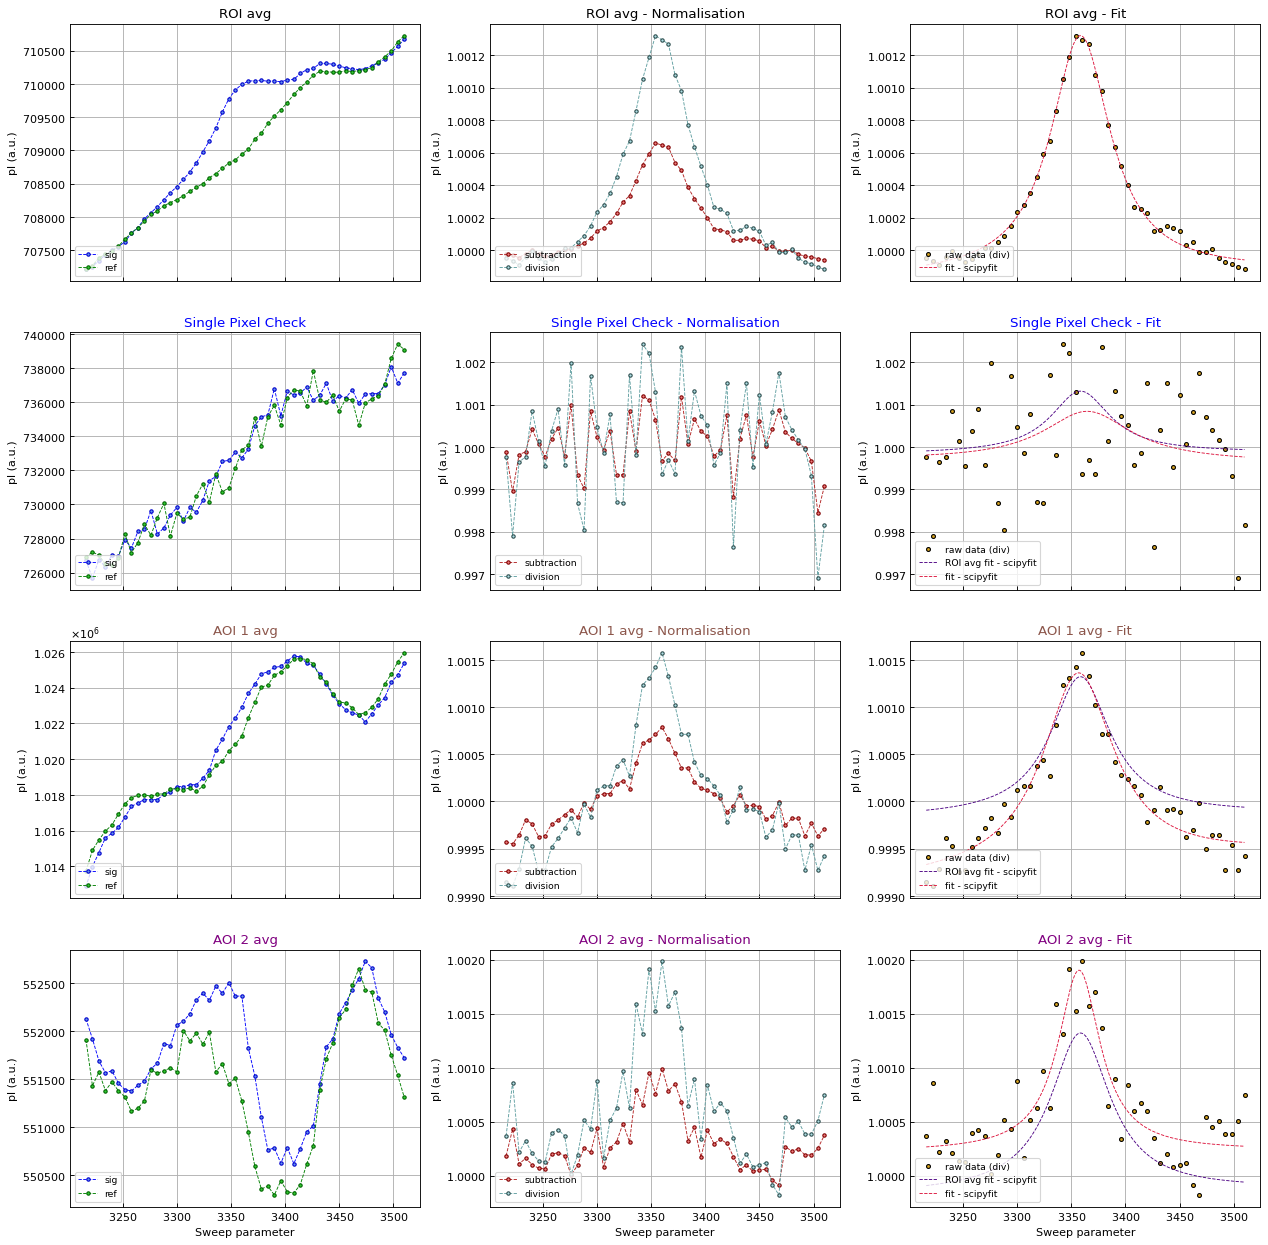

In [15]:
fit_model = qdmpy.pl.define_fit_model(options)
backend_ROI_results_lst = qdmpy.pl.fit_roi_avg_pl(options, sig, ref, sweep_list, fit_model)
ROI_fit_fig = qdmpy.plot.roi_avg_fits(options, backend_ROI_results_lst)

fit_result_collection_lst = qdmpy.pl.fit_aois_pl(options, sig, ref, single_pixel_pl, sweep_list, fit_model, backend_ROI_results_lst)
AOI_fit_fig = qdmpy.plot.aoi_spectra_fit(options, sig, ref, sweep_list, fit_result_collection_lst, fit_model)

In [16]:
wanted_roi_result = next(
    filter(
        lambda result: result.fit_backend == options["fit_backend"], backend_ROI_results_lst
    )
) # ROI fit result for chosen fit backend
pixel_fit_params, sigmas = qdmpy.pl.get_pl_fit_result(options, sig_norm, sweep_list, fit_model, wanted_roi_result)

qdmpy.pl.save_pl_fit_results(options, pixel_fit_params)
qdmpy.pl.save_pl_fit_sigmas(options, sigmas)

pl-scipyfit:   0%|          | 0/3876 [00:00<?, ? PX/s]

In [17]:
ref_fit_params, ref_sigmas = qdmpy.pl.load_ref_exp_pl_fit_results(ref_options)

### Plot (fit) parameters

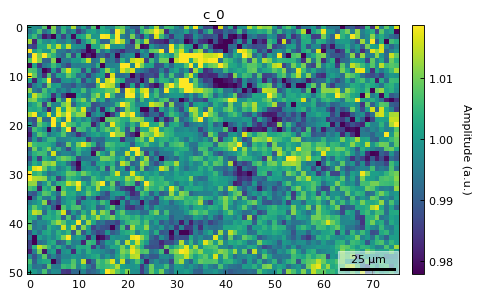

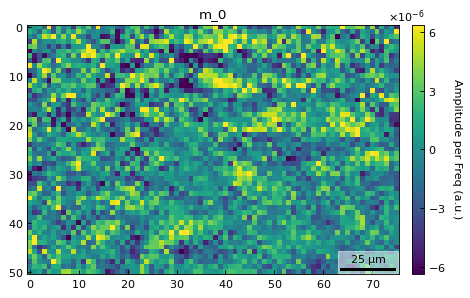

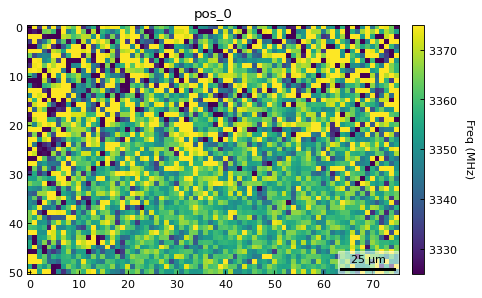

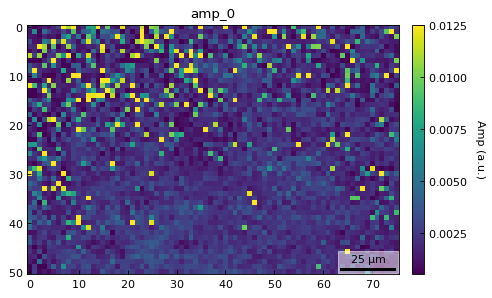

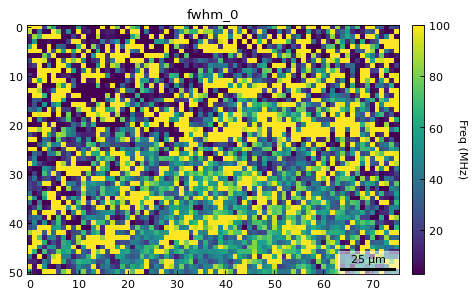

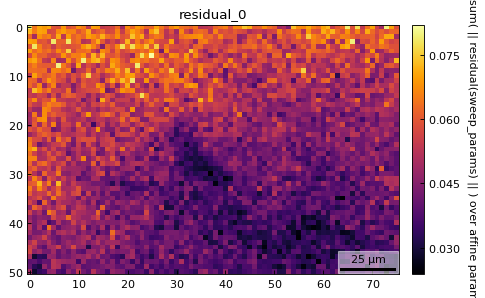

In [18]:
c_fig = qdmpy.plot.pl_param_images(options, fit_model, pixel_fit_params, "c")
m_fig = qdmpy.plot.pl_param_images(options, fit_model, pixel_fit_params, "m")
pos_fig = qdmpy.plot.pl_param_images(options, fit_model, pixel_fit_params, "pos")
amp_fig = qdmpy.plot.pl_param_images(options, fit_model, pixel_fit_params, "amp")
fwhm_fig = qdmpy.plot.pl_param_images(options, fit_model, pixel_fit_params, "fwhm")
residual_fig = qdmpy.plot.pl_param_images(options, fit_model, pixel_fit_params, "residual")

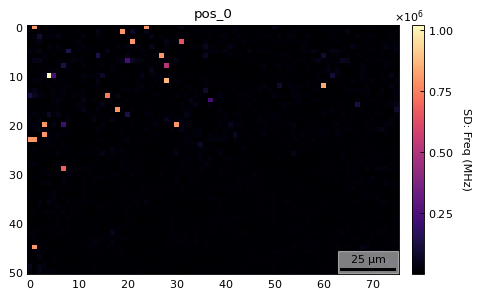

In [19]:
pos_sigma_plot = qdmpy.plot.pl_param_images(options, fit_model, sigmas, "pos", errorplot=True)

### Field retrieval

In [20]:
field_res = qdmpy.field.odmr_field_retrieval(options, pixel_fit_params, ref_fit_params)
(sig_bnvs, ref_bnvs, bnvs), (sig_dshifts, ref_dshifts), (sig_params, ref_params, field_params), (sig_field_sigmas, ref_field_sigmas, field_sigmas) = field_res
qdmpy.field.save_field_calcs(options, *field_res)

/home/samsc/src/qs/qdmpy_proj/qdmpy_git/src/qdmpy/plot/common.py:360: RuntimeWarning: All-NaN slice encountered
  return [np.nanmin(image), np.nanmax(image)]


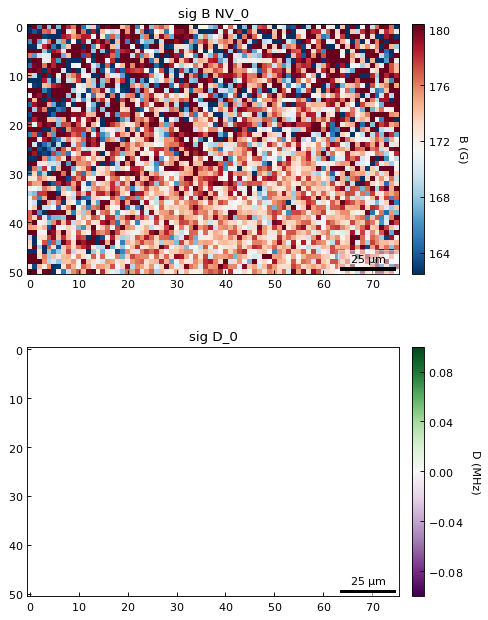

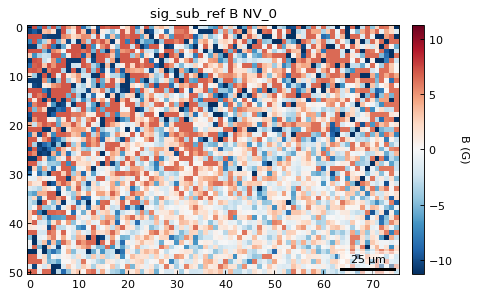

In [21]:
bnv_sig_plot = qdmpy.plot.bnvs_and_dshifts(options, "sig", sig_bnvs, sig_dshifts)
bnv_ref_plot = qdmpy.plot.bnvs_and_dshifts(options, "ref", ref_bnvs, ref_dshifts)
bnvs_plot = qdmpy.plot.bnvs_and_dshifts(options, "sig_sub_ref", bnvs, [])

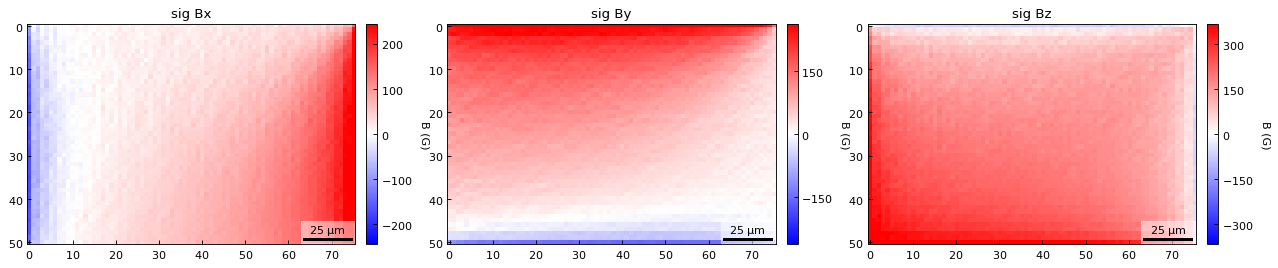

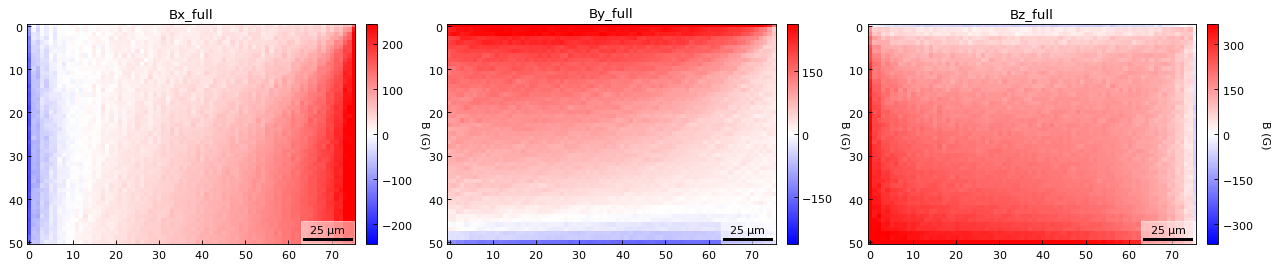

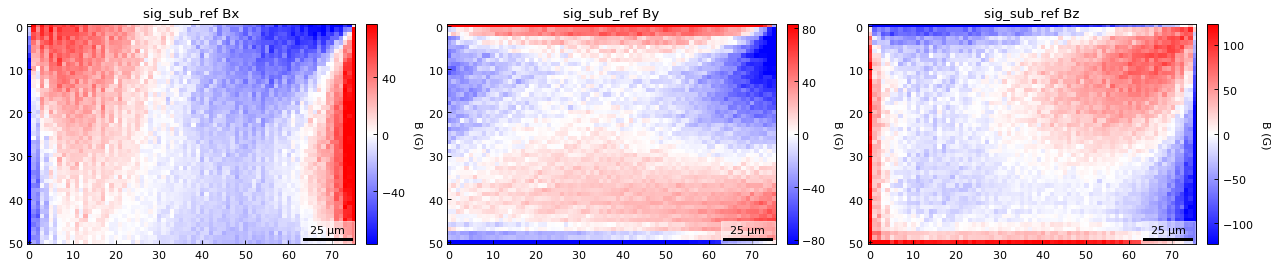

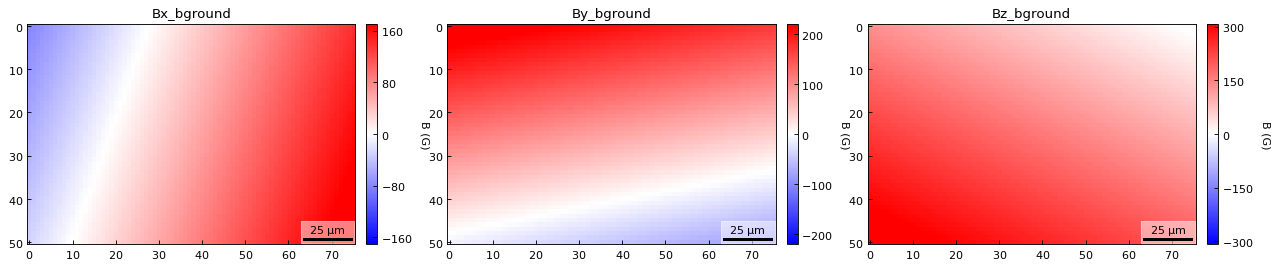

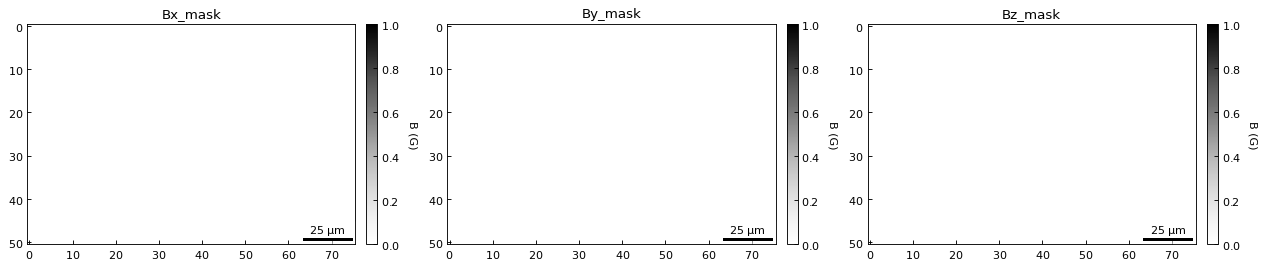

In [22]:
bfield_sig_plot = qdmpy.plot.bfield(options, "sig", sig_params)
bfield_ref_plot = qdmpy.plot.bfield(options, "ref", ref_params)
no_bsub_plot = qdmpy.plot.bfield(options, "full", field_params)
bfield_plot = qdmpy.plot.bfield(options, "sig_sub_ref", field_params)
bfield_bground_plot = qdmpy.plot.bfield(options, "bground", field_params)
bfield_bground_plot = qdmpy.plot.bfield(options, "mask", field_params)

In [23]:
D_sig_plot = qdmpy.plot.dshift_fit(options, "sig", sig_params)
D_ref_plot = qdmpy.plot.dshift_fit(options, "ref", ref_params)

/home/samsc/src/qs/qdmpy_proj/qdmpy_git/src/qdmpy/shared/misc.py:17: QDMPYWarning: 'D' param missing from field_params, skipping Dshift_fit plot.
  warnings.warn(msg, QDMPYWarning)


In [24]:
# Bx_fit_flat_plot = qdmpy.plot.field_param_flattened(options, "sig", "Bx", sig_params, sigmas=sig_field_sigmas, y_label="B (G)", errorevery=1000, plot_guess=False)

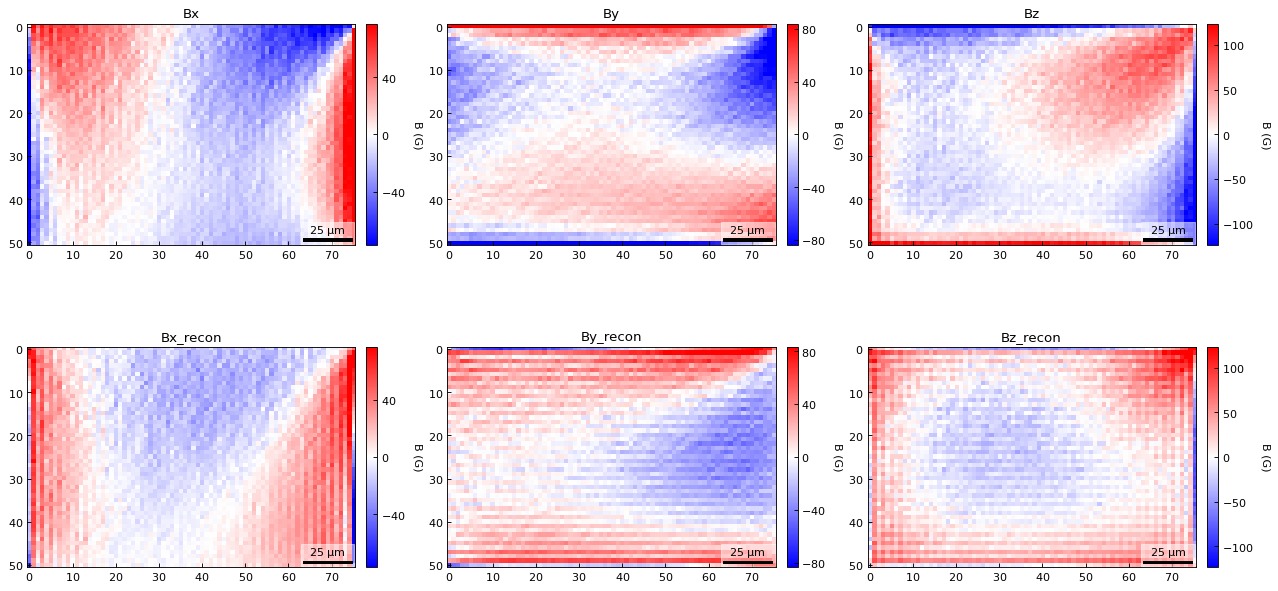

In [25]:
bconsist_plot = qdmpy.plot.bfield_consistency(options, "sig_sub_ref", field_params)

### Save and (optionally) view options dict

In [26]:
qdmpy.save_options(options)
# import qdmpy.shared.json2dict; print(qdmpy.shared.json2dict.dict_to_json_str(options))